<a href="https://colab.research.google.com/github/martadftese/hello-world/blob/master/ImplementacaoK_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##I. Descrição do problema##

Dataset  composto por 603.575 medidas de PA de 7.915 pacientes , sendo divididas em SBP e DBP.

Medidas coletadas a cada 15´ em 3 turnos e 30´ em 1 turno = 82 medidas em 24h

Há 12,65% de pacientes com ao menos 1 MIssing Value

Há 9 tipos de Doenças Padrão conhecidas: White-Coat, Dipping, Non-Dipping, Masked, Ambulatory Hypotension, Isolated Systolic, Isolated Diastolic, Reverse Dipping, Morning Surge. E um padrão, que não é considerado doença, mas deve compor a classificacção que é Normotenso.

**Objetivo:** clusterizar os padrões de doenças 

Doubts: Como lidar com Missing Data ? 

**DEFINIÇÕES**

IDADE >=60 then é idoso, else é jovem

**PERÍODOS**

* Matutino: 6h-8h59
* Diurno: 9h-20h59
* Vespertino: 21h-22h59
* Noturno: 23h-05h59

MEDIDAS_POR_JANELA = 10


**Para SBP:**

LINHA_MAX = 140			LINHA_MIN = 100		

**Para DBP:**

LINHA_MAX = 90			LINHA_MIN = 60

**PADRÕES de DOENÇAS**

* WHITE COAT: 1a. média SBP >= todas outras médias
* MASKED:   if NOTURNO and any SBP>=140,  informar qtde de janelas >=140
* AMBULATORY HIPOTENSION: if any SBP <90 or any DBP <60
* ISOLATED SYSTOLIC:  if any SBP >140 and 60< DBP <90 ?????? 
* ISOLATED DIASTOLIC:  100< SBP <140 and any DBP >90
* DIPPING:  calcular SPB diurna; calcular SBP noturna; 
   Calcular dif=% da SBP noturna comparado com a diurna
      if 10< dif < 20 then DIPPING
      if dif > 10 then NON DIPPING
      if dif > 20 then EXTREME DIPPING
* REVERSE DIPPING: if SBP Noturna >= SBP Diurna
* MORNING SURGE:  if DIPPING, calcular SBP matinal
      if SBP matinal > 10% da SBP Noturna
* NORMOTENSA



##Abordagem do problema##

Tipo de aprendizagem:  Aprendizagem não supervisionada (Clausterização)

Dados: Dataset com 7.915 pacientes e 603.576 medidas de Pressão Arterial (PA) considerando a Sistólica (SBP) e Diastólica (DSP) coletadas por 24 horas, sendo a cada 15 minutos nos períodos Diurno, Matutino, Vespertino e a cada 30 minutos no período Noturno. Dessa forma, totalizamos 82 medidas diárias por paciente. Essa base de dados contém pacientes do gênero masculino e feminino com idade mínima de 10 anos e máxima de 100 anos. O método de coleta das medidas foi realizado com metodologia padrão acreditada pela American College of Cardiology/American Heart Association Task Force.

Modelo:

Objetivo: Utilizar método de análise automatizada para identificar e classificar cada paciente nos nove padrões de doenças Hipertensiva e um padrão normal descrita pela sociedade médica e, identificar padrões não conhecidos, caso existam.

Críterio:

Técnica de otimização: K-means

##Tratamento da base de dados##

Importa as bibliotecas necessárias

In [0]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial import distance
import matplotlib.pyplot as plt
import datetime


%matplotlib inline

Carrega a base de dados e exibe os 5 primeiros pacientes

In [0]:
filepath = '/content/base_completa_sem_nome_normalizada.csv'
df = pd.read_csv(filepath,encoding='cp860',sep=';')
df.head()

,numero_identificacao,data_nascimento,genero,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,sist 10:45,sist 11:00,sist 11:15,sist 11:30,sist 11:45,sist 12:00,sist 12:15,sist 12:30,sist 12:45,sist 13:00,sist 13:15,sist 13:30,sist 13:45,sist 14:00,sist 14:15,sist 14:30,sist 14:45,sist 15:00,sist 15:15,sist 15:30,sist 15:45,sist 16:00,sist 16:15,sist 16:30,sist 16:45,sist 17:00,sist 17:15,sist 17:30,sist 17:45,sist 18:00,...,diast 19:00,diast 19:15,diast 19:30,diast 19:45,diast 20:00,diast 20:15,diast 20:30,diast 20:45,diast 21:00,diast 21:15,diast 21:30,diast 21:45,diast 22:00,diast 22:15,diast 22:30,diast 22:45,diast 23:00,diast 23:30,diast 0:00,diast 0:30,diast 1:00,diast 1:30,diast 2:00,diast 2:30,diast 3:00,diast 3:30,diast 4:00,diast 4:30,diast 5:00,diast 5:30,diast 6:00,diast 6:30,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45
0,4,05/10/1923,M,105.0,108.0,116.0,104.0,106.0,98.0,NaN,107.0,NaN,117.0,NaN,NaN,NaN,NaN,140.0,NaN,NaN,NaN,NaN,119.0,92.0,NaN,112.0,104.0,135.0,103.0,93.0,NaN,126.0,128.0,132.0,127.0,NaN,137.0,126.0,NaN,NaN,...,64.0,59.0,69.0,61.0,NaN,67.0,71.0,68.0,59.0,57.0,75.0,59.0,69.0,NaN,68.0,56.0,76.0,73.0,NaN,66.0,56.0,60.0,37.0,59.0,74.0,44.0,34.0,55.0,70.0,38.0,48.0,41.0,NaN,NaN,NaN,67.0,61.0,69.0,62.0,51.0
1,5,07/10/1948,M,103.0,114.0,82.0,104.0,98.0,106.0,108.0,107.0,109.0,100.0,106.0,119.0,102.0,90.0,104.0,103.0,106.0,112.0,113.0,89.0,105.0,101.0,106.0,106.0,116.0,103.0,114.0,110.0,102.0,101.0,102.0,95.0,102.0,109.0,104.0,102.0,108.0,...,65.0,57.0,66.0,58.0,70.0,70.0,67.0,68.0,71.0,61.0,62.0,59.0,61.0,62.0,50.0,48.0,47.0,60.0,65.0,69.0,62.0,48.0,62.0,67.0,65.0,60.0,66.0,62.0,64.0,72.0,74.0,NaN,74.0,77.0,NaN,NaN,60.0,74.0,70.0,67.0
2,6,23/03/1999,M,147.0,148.0,156.0,140.0,130.0,132.0,121.0,113.0,149.0,128.0,122.0,126.0,146.0,139.0,139.0,144.0,144.0,124.0,124.0,124.0,126.0,131.0,136.0,138.0,142.0,130.0,156.0,136.0,145.0,145.0,138.0,142.0,129.0,118.0,139.0,129.0,114.0,...,33.0,67.0,66.0,76.0,85.0,91.0,84.0,90.0,90.0,85.0,74.0,80.0,78.0,82.0,85.0,88.0,90.0,87.0,82.0,89.0,78.0,61.0,69.0,54.0,62.0,57.0,59.0,62.0,54.0,56.0,62.0,80.0,93.0,NaN,NaN,NaN,86.0,87.0,82.0,82.0
3,7,26/01/1978,F,140.0,139.0,142.0,137.0,135.0,177.0,148.0,152.0,135.0,136.0,130.0,159.0,147.0,146.0,150.0,157.0,144.0,137.0,74.0,121.0,131.0,135.0,123.0,122.0,113.0,140.0,142.0,139.0,142.0,139.0,140.0,137.0,128.0,126.0,122.0,118.0,140.0,...,72.0,86.0,75.0,81.0,82.0,65.0,87.0,82.0,87.0,79.0,77.0,80.0,73.0,80.0,95.0,92.0,78.0,72.0,60.0,64.0,62.0,74.0,74.0,71.0,67.0,87.0,89.0,90.0,80.0,83.0,79.0,49.0,62.0,NaN,104.0,82.0,NaN,89.0,90.0,72.0
4,8,07/03/1990,M,NaN,110.0,101.0,108.0,111.0,111.0,114.0,115.0,113.0,112.0,120.0,118.0,116.0,120.0,115.0,113.0,NaN,107.0,120.0,117.0,118.0,118.0,NaN,130.0,NaN,123.0,NaN,121.0,123.0,130.0,154.0,119.0,NaN,NaN,108.0,121.0,116.0,...,78.0,86.0,79.0,114.0,NaN,NaN,NaN,87.0,83.0,NaN,NaN,77.0,86.0,80.0,75.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,53.0,50.0,64.0,40.0,41.0,54.0,69.0,73.0,48.0,64.0,NaN,93.0,68.0,NaN,65.0,NaN,81.0,72.0


Seleciona os dados de pressão sistólica e diastólica para compor as entradas do algoritmo de aprendizagem

In [0]:
# Identifica o tamanho do dataset e os nomes das colunas
print('Size of dataset: ' + str(df.shape ))
print(list(df))  # print feature list

data_input = df.loc[:,'sist 9:00':'diast 8:45']
data_input.values
data_input.shape

Size of dataset: (7711, 163)
['numero_identificacao', 'data_nascimento', 'genero', 'sist 9:00', 'sist 9:15', 'sist 9:30', 'sist 9:45', 'sist 10:00', 'sist 10:15', 'sist 10:30', 'sist 10:45', 'sist 11:00', 'sist 11:15', 'sist 11:30', 'sist 11:45', 'sist 12:00', 'sist 12:15', 'sist 12:30', 'sist 12:45', 'sist 13:00', 'sist 13:15', 'sist 13:30', 'sist 13:45', 'sist 14:00', 'sist 14:15', 'sist 14:30', 'sist 14:45', 'sist 15:00', 'sist 15:15', 'sist 15:30', 'sist 15:45', 'sist 16:00', 'sist 16:15', 'sist 16:30', 'sist 16:45', 'sist 17:00', 'sist 17:15', 'sist 17:30', 'sist 17:45', 'sist 18:00', 'sist 18:15', 'sist 18:30', 'sist 18:45', 'sist 19:00', 'sist 19:15', 'sist 19:30', 'sist 19:45', 'sist 20:00', 'sist 20:15', 'sist 20:30', 'sist 20:45', 'sist 21:00', 'sist 21:15', 'sist 21:30', 'sist 21:45', 'sist 22:00', 'sist 22:15', 'sist 22:30', 'sist 22:45', 'sist 23:00', 'sist 23:30', 'sist 0:00', 'sist 0:30', 'sist 1:00', 'sist 1:30', 'sist 2:00', 'sist 2:30', 'sist 3:00', 'sist 3:30', 'sist

(7711, 160)

Identifica as células onde os valores estão nulos, ou seja, tentativas de medições em que ocorreram erros

In [0]:
# Verifica quais células apresentam NaN
null_values = data_input.isnull()
# Checa quais pacientes possuem mais de duas medidas consecutivas faltantes
null_values.rolling(window=3, axis=1,min_periods=1).sum()>1
index_1 = null_values[null_values.rolling(window=3, axis=1,min_periods=1).sum()>1]
new_input = data_input[index_1.apply(np.sum,axis=1)==0]
new_input.head(10)
indices = list(new_input)

F    357
M    342
Name: genero, dtype: int64


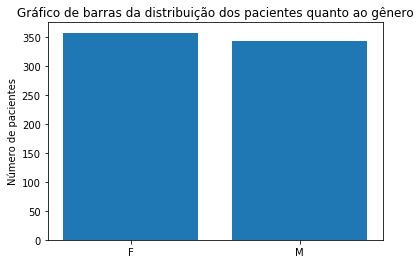

In [0]:
gender = df.iloc[new_input.index]['genero'].value_counts()
plt.bar(gender.index,gender)
plt.gca().set(title='Gráfico de barras da distribuição dos pacientes quanto ao gênero', ylabel='Número de pacientes')
print(gender)

Analisa a distribuição do dataset quanto a idade dos pacientes

[Text(0, 0.5, 'Frequência'),
 Text(0.5, 0, 'Idade'),
 Text(0.5, 1.0, 'Histograma de Frequência segundo a idade dos pacientes')]

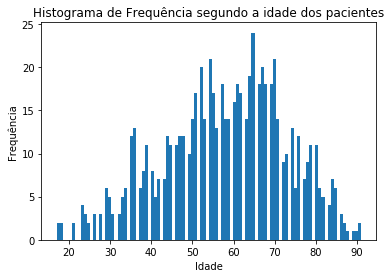

In [0]:
data_nascimento = pd.to_datetime(df.iloc[new_input.index]['data_nascimento']).dt.date
data_atual = datetime.date.today()
idade = (data_atual - data_nascimento).astype('<m8[Y]')
plt.hist(idade,bins=100)
plt.gca().set(title='Histograma de Frequência segundo a idade dos pacientes', ylabel='Frequência', xlabel='Idade')

Realiza o preenchimento dos dados faltantes utilizando a média dos valor imediatamente anterior e do valor imediatamente posterior

In [0]:
# Encontra os índices nos quais há o valor faltante
for i in range(len(new_input)):
  zero_index = new_input.columns[new_input.isnull().iloc[i]]
  for j in range(len(zero_index)):
    index_column = indices.index(zero_index[j])
    if(index_column==0):
      new_input.iloc[i][index_column] = new_input.iloc[i][index_column+1]
    elif(index_column==79):
      new_input.iloc[i][index_column] = new_input.iloc[i][index_column-1]
    if(index_column==80):
      new_input.iloc[i][index_column] = new_input.iloc[i][index_column+1]
    elif(index_column==159):
      new_input.iloc[i][index_column] = new_input.iloc[i][index_column-1]
    else:
      new_input.iloc[i][index_column] = (new_input.iloc[i][index_column-1]+ new_input.iloc[i][index_column+1])/2
 # quantidade de linhas e colunas na tabela
new_input.shape

(699, 160)

Visualizando os dados de pressão sistólica e diastólica de um paciente aleatório

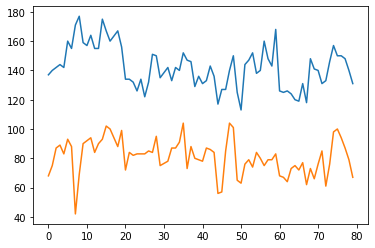

In [0]:
index = np.random.randint(0,699)
plt.plot(np.arange(80),new_input.iloc[index,0:80])
plt.plot(np.arange(80),new_input.iloc[index,80:160])

Calcula a média das pressões sistólica e diastólica para cada um dos pacientes

In [0]:
ps_mean = np.mean(new_input.iloc[:,0:80],axis=1)
pd_mean = np.mean(new_input.iloc[:,80:160],axis=1)
new_input['PS Media'] = ps_mean
new_input['PD Media'] = pd_mean
new_input.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,sist 10:45,sist 11:00,sist 11:15,sist 11:30,sist 11:45,sist 12:00,sist 12:15,sist 12:30,sist 12:45,sist 13:00,sist 13:15,sist 13:30,sist 13:45,sist 14:00,sist 14:15,sist 14:30,sist 14:45,sist 15:00,sist 15:15,sist 15:30,sist 15:45,sist 16:00,sist 16:15,sist 16:30,sist 16:45,sist 17:00,sist 17:15,sist 17:30,sist 17:45,sist 18:00,sist 18:15,sist 18:30,sist 18:45,...,diast 19:30,diast 19:45,diast 20:00,diast 20:15,diast 20:30,diast 20:45,diast 21:00,diast 21:15,diast 21:30,diast 21:45,diast 22:00,diast 22:15,diast 22:30,diast 22:45,diast 23:00,diast 23:30,diast 0:00,diast 0:30,diast 1:00,diast 1:30,diast 2:00,diast 2:30,diast 3:00,diast 3:30,diast 4:00,diast 4:30,diast 5:00,diast 5:30,diast 6:00,diast 6:30,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45,PS Media,PD Media
3,140.0,139.0,142.0,137.0,135.0,177.0,148.0,152.0,135.0,136.0,130.0,159.0,147.0,146.0,150.0,157.0,144.0,137.0,74.0,121.0,131.0,135.0,123.0,122.0,113.0,140.0,142.0,139.0,142.0,139.0,140.0,137.0,128.0,126.0,122.0,118.0,140.0,127.0,129.0,114.0,...,75.0,81.0,82.0,65.0,87.0,82.0,87.0,79.0,77.0,80.0,73.0,80.0,95.0,92.0,78.0,72.0,60.0,64.0,62.0,74.0,74.0,71.0,67.0,87.0,89.0,90.0,80.0,83.0,79.0,49.0,62.0,83.0,104.0,82.0,85.5,89.0,90.0,72.0,132.66250,79.39375
6,122.0,119.0,117.0,115.0,110.0,108.0,120.0,116.0,135.0,126.0,125.0,124.0,126.0,127.0,127.0,121.0,121.0,119.0,118.0,125.0,130.0,145.0,135.0,132.0,125.0,119.0,127.0,129.0,136.0,132.0,133.0,130.0,133.0,127.0,126.0,131.0,124.0,124.0,135.0,130.0,...,66.0,67.0,67.0,66.0,75.0,74.0,75.0,73.0,76.0,73.0,76.0,71.0,67.0,80.0,67.0,69.0,81.0,87.0,93.0,77.0,57.0,68.0,73.0,75.0,76.0,85.0,90.0,96.0,61.0,60.0,50.0,40.0,67.0,69.0,97.0,95.0,93.5,92.0,122.02500,76.20625
40,126.0,121.0,125.0,120.0,119.0,140.0,110.0,115.0,115.0,106.0,115.0,115.0,117.0,115.0,108.0,109.0,112.0,115.0,110.0,118.0,113.0,107.0,120.0,115.0,115.0,116.0,113.0,115.0,124.0,120.0,125.0,121.0,124.0,122.0,120.0,123.0,112.0,112.0,118.0,139.0,...,80.0,81.0,66.0,72.0,68.0,68.0,65.0,64.0,65.0,65.0,71.0,69.0,69.0,68.0,67.5,67.0,68.0,59.0,67.0,70.0,69.0,69.0,64.0,72.0,77.0,80.0,76.0,85.0,87.0,88.0,91.0,82.0,88.0,88.5,89.0,84.0,83.0,86.0,116.82500,76.02500
53,144.0,148.0,128.0,125.0,116.0,129.0,138.0,128.0,121.0,117.0,140.0,136.0,141.0,132.0,121.0,121.0,114.0,107.0,112.0,153.0,94.0,114.0,130.0,136.0,128.0,115.0,125.0,141.0,138.0,139.0,136.0,124.0,120.0,116.0,146.0,165.0,143.0,167.0,151.0,153.0,...,90.0,64.0,71.0,58.0,70.0,64.0,65.0,75.0,78.0,73.0,69.0,79.0,59.0,58.0,60.0,63.0,36.0,34.0,35.0,33.0,37.0,39.0,34.0,40.0,55.0,55.0,51.0,53.0,54.0,46.0,58.0,67.0,79.0,72.0,62.0,63.0,59.0,81.0,128.26250,61.78750
60,129.0,126.0,116.0,122.5,129.0,145.0,141.0,134.0,138.0,134.0,132.0,115.0,125.0,109.0,119.0,129.0,155.0,135.0,125.0,122.0,117.0,118.0,121.0,119.0,121.0,119.0,121.0,120.0,117.0,151.0,163.0,133.0,137.0,140.0,128.0,123.0,112.0,103.0,119.0,118.0,...,108.0,102.0,98.0,105.0,98.0,88.0,96.0,95.0,101.0,86.0,105.0,94.0,95.0,77.0,84.0,82.0,66.0,68.0,55.0,68.0,64.0,54.0,67.0,66.0,49.0,62.0,59.0,57.0,57.0,60.0,65.0,63.0,61.0,55.0,68.0,75.0,82.0,91.0,124.94375,81.14375


In [0]:
print(list(new_input))

['sist 9:00', 'sist 9:15', 'sist 9:30', 'sist 9:45', 'sist 10:00', 'sist 10:15', 'sist 10:30', 'sist 10:45', 'sist 11:00', 'sist 11:15', 'sist 11:30', 'sist 11:45', 'sist 12:00', 'sist 12:15', 'sist 12:30', 'sist 12:45', 'sist 13:00', 'sist 13:15', 'sist 13:30', 'sist 13:45', 'sist 14:00', 'sist 14:15', 'sist 14:30', 'sist 14:45', 'sist 15:00', 'sist 15:15', 'sist 15:30', 'sist 15:45', 'sist 16:00', 'sist 16:15', 'sist 16:30', 'sist 16:45', 'sist 17:00', 'sist 17:15', 'sist 17:30', 'sist 17:45', 'sist 18:00', 'sist 18:15', 'sist 18:30', 'sist 18:45', 'sist 19:00', 'sist 19:15', 'sist 19:30', 'sist 19:45', 'sist 20:00', 'sist 20:15', 'sist 20:30', 'sist 20:45', 'sist 21:00', 'sist 21:15', 'sist 21:30', 'sist 21:45', 'sist 22:00', 'sist 22:15', 'sist 22:30', 'sist 22:45', 'sist 23:00', 'sist 23:30', 'sist 0:00', 'sist 0:30', 'sist 1:00', 'sist 1:30', 'sist 2:00', 'sist 2:30', 'sist 3:00', 'sist 3:30', 'sist 4:00', 'sist 4:30', 'sist 5:00', 'sist 5:30', 'sist 6:00', 'sist 6:30', 'sist 7:0

In [0]:
# Implementação de PCA para extração de features


## Clusterização de pacientes com dipping ou non-dipping utilizando o k-means

In [0]:
# Identifica o tamanho do dataset e os nomes das colunas
print('Size of dataset: ' + str(df.shape ))
#print(list(df))  # print feature list

# Cria um novo dataset
media = {'PS Diff':pd.concat([new_input.loc[:,'sist 9:00':'sist 22:45'],new_input.loc[:,'sist 6:00':'sist 8:45']], axis=1, sort=False).mean(axis=1)/new_input.loc[:,'sist 23:00':'sist 5:30'].mean(axis=1),'PD Diff':pd.concat([new_input.loc[:,'diast 9:00':'diast 22:45'],new_input.loc[:,'diast 6:00':'diast 8:45']], axis=1, sort=False).mean(axis=1)/new_input.loc[:,'diast 23:00':'diast 5:30'].mean(axis=1)}
input_media = pd.DataFrame(media)
input_media.head()

start_noite = new_input.columns.get_loc("sist 23:00")
end_noite = new_input.columns.get_loc("sist 5:30")

Size of dataset: (7711, 163)


### Implementação com a inicialização dos representantes dos clusters inseridas manualmente

Realiza a clusterização usando o K-means

In [0]:
# Define o número de centroides/clusters
n_centr = 4
#n_centr = 2
# Define o número de elementos do centroide
n_elem = 2
# Inicializa os centroides
mi = np.zeros((n_centr,n_elem))
mi[0] = [0.8, 0.8]
mi[1] = [1.0,1.0]
#mi[1] = [1.3,1.3]
mi[2] = [1.1,1.1]
mi[3] = [1.3,1.3]
mi_old = np.copy(mi)
D = np.zeros((699,n_centr))
z = np.zeros((699,n_centr))
deltaMi = 1000
counter = 0
while(deltaMi>0.001):
  for i in range(699):
    for j in range(n_centr):
      D[i,j] = distance.euclidean(input_media.iloc[i,0:n_elem].values,mi[j])
  for i in range(699):
    for j in range(n_centr):
        if(j == np.argmin(D[i,:])):
          z[i,j] = 1
        else:
          z[i,j] = 0
  # Etapa de Maximização - Maximization Step
  for j in range(n_centr):
    z_sum = 0
    for i in range(699):
      z_sum = z_sum + z[i,j]*(input_media.iloc[i,0:n_elem].values)
    mi[j] = z_sum/np.sum(z[:,j])
  deltaMi = np.abs(np.sum(np.sum(mi-mi_old)))
  print(deltaMi)
  mi_old = np.copy(mi)

0.13175865543428156
0.06790425124154487
0.042471849986255084
0.030559996699826897
0.03669781404252481
0.029008906158493275
0.03337657814202877
0.03208890717899826
0.021678045329339923
0.01950399067954045
0.015041631581593773
0.014371942732297471
0.008195946118793151
0.010060985298145808
0.013418197117460173
0.013348936438323689
0.009548860568093565
0.015067696919409124
0.014944839261903486
0.008765400346007923
0.0151479825444496
0.012761094135897655
0.021362123821770496
0.01149163440165224
0.009377790405795117
0.0064794066121387495
0.008389240319512714
0.00110621245182696
0.0019085236190100607
0.0022293236206309963
0.0007774287679644942


Plota os clusters inserindo tendo o eixo x como o percentual entre as médias da pressão sistólica média e o eixo y como o percentual das médias da pressão diastólica

[[0.96989853 0.99103178]
 [1.05601663 1.09941196]
 [1.13487705 1.21525863]
 [1.22538076 1.36696887]]


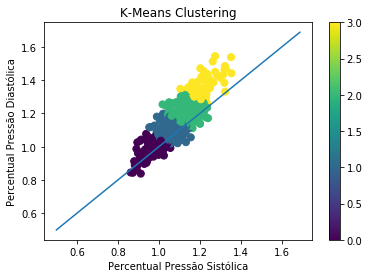

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(input_media['PS Diff'],input_media['PD Diff'],
                     c=np.where(z==1)[1],s=50,cmap='viridis')
ax.set_title('K-Means Clustering')
ax.set_xlabel('Percentual Pressão Sistólica')
ax.set_ylabel('Percentual Pressão Diastólica')
plt.plot(1.2*np.arange(100)/100+0.5,1.2*np.arange(100)/100 +0.5)
plt.colorbar(scatter)
plt.savefig('K-means.png')
print(mi)

Seleciona um representante de cada cluster e plota o gráfico

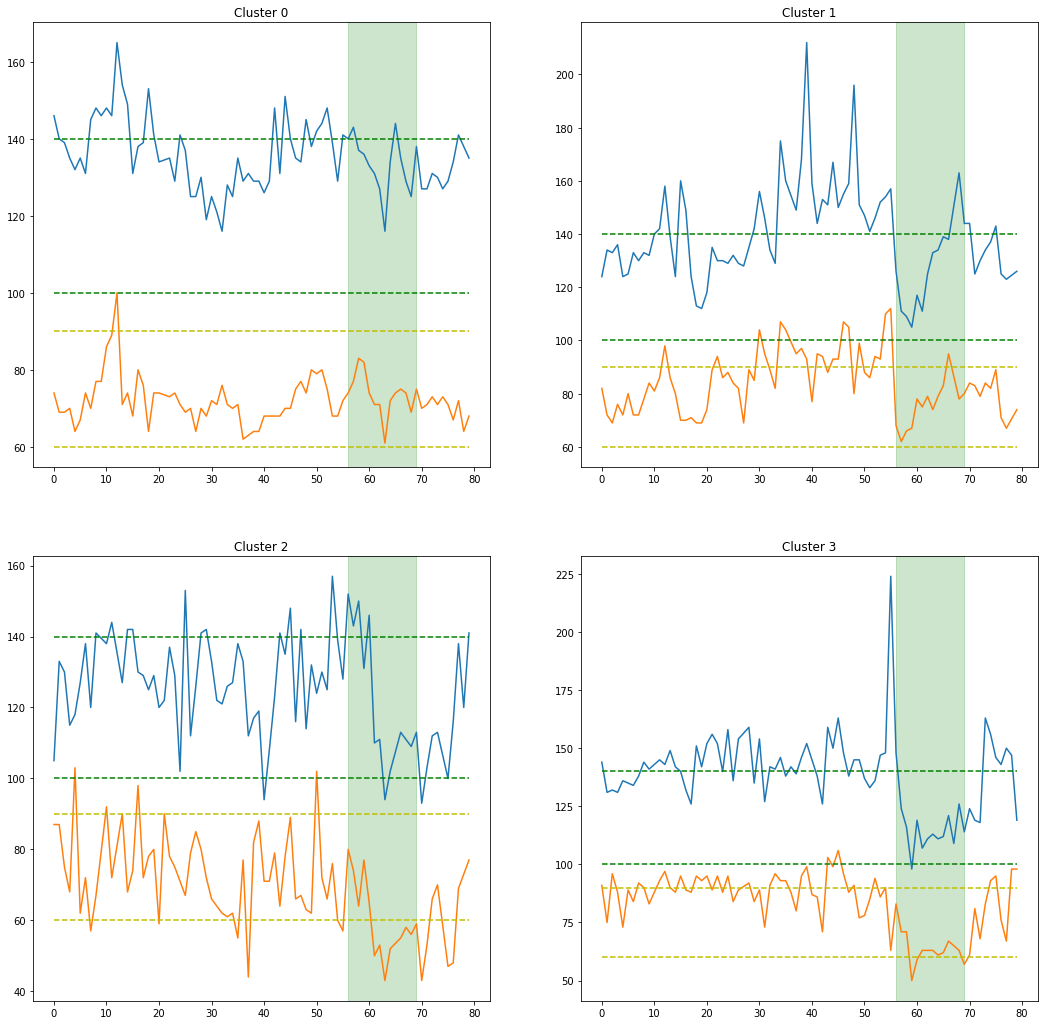

In [0]:
# Identifica os clusters que representam cada um dos dados de entrada
nrows = np.where(z==1)
#print(nrows[1])
#print(mi[1])
figure1, axs = plt.subplots(int(n_centr/2),2,figsize=(18,18))
for i in range(int(np.around(n_centr/2))):
  cluster = np.where(nrows[1]==2*i)
  index = np.random.choice(cluster[0])
  axs[i,0].plot(np.arange(80),new_input.iloc[index,0:80])
  axs[i,0].plot(np.arange(80),new_input.iloc[index,80:160])
  axs[i,0].plot(np.arange(80),140*np.ones((80,1)),'g--')
  axs[i,0].plot(np.arange(80),100*np.ones((80,1)),'g--')
  axs[i,0].plot(np.arange(80),90*np.ones((80,1)),'y--')
  axs[i,0].plot(np.arange(80),60*np.ones((80,1)),'y--')
  axs[i,0].axvspan(start_noite, end_noite, color='green', alpha=0.2)
  axs[i,0].set_title('Cluster {}'.format(2*i))
  cluster = np.where(nrows[1]==(2*i+1))
  index = np.random.choice(cluster[0])
  axs[i,1].plot(np.arange(80),new_input.iloc[index,0:80])
  axs[i,1].plot(np.arange(80),new_input.iloc[index,80:160])
  axs[i,1].plot(np.arange(80),140*np.ones((80,1)),'g--')
  axs[i,1].plot(np.arange(80),100*np.ones((80,1)),'g--')
  axs[i,1].plot(np.arange(80),90*np.ones((80,1)),'y--')
  axs[i,1].plot(np.arange(80),60*np.ones((80,1)),'y--')
  axs[i,1].axvspan(start_noite, end_noite, color='green', alpha=0.2)
  axs[i,1].set_title('Cluster {}'.format(2*i+1))
plt.savefig('clusters1.png')

### Inicialização dos representantes dos cluster fazendo a escolha aleatória sobre o dataset de entrada

Realiza a clusterização com a inicialização dos representantes dos clusteres de maneira aleatória, escolhendo-os randomicamente com base nos dados de entrada 

In [0]:
# Define o número de centroides/clusters
n_centr = 4
# Define o número de elementos do centroide
n_elem = 2
# Inicializa os centroides aleatoriamente
mi = input_media.sample(n_centr)
## Etapa de Expectativa (Expectation Step)
# Matriz de distâncias usando a distância Bray Curtis
#D = distance.braycurtis()
# Matriz de distâncias usando a distância Chebyshev
D = np.zeros((699,n_centr))
z = np.zeros((699,n_centr))
mi_old = np.copy(mi)
counter = 0
deltaMi = 1000
while(deltaMi>0.001):
  for i in range(699):
    for j in range(n_centr):
      D[i,j] = distance.euclidean(input_media.iloc[i,0:n_elem].values,mi.iloc[j])
      
  for i in range(699):
    for j in range(n_centr):
        if(j == np.argmin(D[i,:])):
          z[i,j] = 1
        else:
          z[i,j] = 0
  # Etapa de Maximização - Maximization Step
  for j in range(n_centr):
    z_sum = 0
    for i in range(699):
      z_sum = z_sum + z[i,j]*(input_media.iloc[i,0:n_elem].values)
    mi.iloc[j] = z_sum/np.sum(z[:,j])
    #print(mi)
  counter = counter + 1
  deltaMi = np.abs(np.sum(np.sum(mi-mi_old)))
  print(deltaMi)
  mi_old = np.copy(mi)

0.0320360869537889
0.009602856669613025
0.020307785162979597
0.011786269310254838
0.02360490017444472
0.020732910315451103
0.012767211446066073
0.011004422577759243
0.005006229995531353
0.009158484966334202
0.013752726438515772
0.00671172155713029
0.008733109240329329
0.0019085236190100607
0.0022293236206309963
0.0007774287679644942


Plota os clusters inserindo tendo o eixo x como o percentual entre as médias da pressão sistólica média e o eixo y como o percentual das médias da pressão diastólica

       PS Diff   PD Diff
4435  1.056017  1.099412
7450  1.225381  1.366969
5252  1.134877  1.215259
1261  0.969899  0.991032


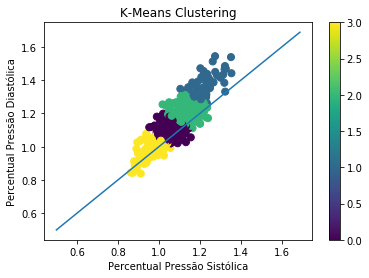

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(input_media['PS Diff'],input_media['PD Diff'],
                     c=np.where(z==1)[1],s=50,cmap='viridis')
ax.set_title('K-Means Clustering')
ax.set_xlabel('Percentual Pressão Sistólica')
ax.set_ylabel('Percentual Pressão Diastólica')
plt.plot(1.2*np.arange(100)/100+0.5,1.2*np.arange(100)/100 +0.5)
plt.colorbar(scatter)
plt.savefig('K-meansRand.png')
print(mi)

### Seleciona um representante de cada cluster e plota o gráfico

[0 3 0 1 1 0 2 0 0 0 3 0 2 0 1 1 2 3 0 0 3 3 2 0 2 3 3 2 0 0 2 3 2 0 2 3 0
 2 0 0 2 0 2 2 0 3 0 2 0 0 0 0 2 0 1 3 0 0 2 3 2 2 3 3 0 0 0 0 0 0 1 2 2 0
 0 2 3 2 3 2 0 2 0 2 0 3 0 3 0 2 0 0 0 0 0 0 2 2 2 0 0 3 2 2 0 2 1 2 0 0 2
 1 3 2 0 3 3 0 2 3 0 0 2 0 2 3 0 0 2 0 0 2 2 2 0 0 0 3 0 2 0 2 3 0 2 0 2 2
 2 1 0 0 0 0 2 2 3 3 0 2 0 0 0 1 2 2 3 2 1 2 0 2 2 1 1 2 3 2 0 2 2 0 3 3 3
 0 0 3 3 2 0 3 0 0 0 3 3 3 0 1 0 3 0 2 2 2 3 2 0 3 1 2 2 3 0 0 0 0 2 0 0 2
 0 3 2 3 0 0 0 0 2 2 0 0 2 0 0 2 2 0 1 1 2 0 0 0 2 2 0 0 0 3 2 1 0 0 2 2 2
 0 1 0 2 1 1 1 2 1 2 2 1 0 2 0 2 1 2 2 0 2 3 3 2 3 1 0 3 0 2 0 0 3 3 0 0 0
 0 2 0 2 0 0 0 3 0 0 0 2 0 0 2 2 3 2 0 1 0 0 3 1 2 3 0 1 0 0 3 2 0 0 0 3 2
 0 3 0 1 1 0 0 2 3 0 3 1 3 0 2 0 1 2 0 2 3 0 2 2 0 0 2 2 0 0 3 2 1 3 0 1 0
 0 3 0 0 3 2 2 0 2 2 2 3 3 0 3 0 2 3 0 0 3 2 2 3 3 0 2 3 2 3 0 0 2 0 0 2 3
 3 2 3 3 2 2 2 0 2 3 3 0 0 1 3 2 2 0 0 3 0 2 0 0 3 0 3 0 0 2 2 2 0 0 0 2 3
 3 0 2 2 2 0 0 0 0 0 0 2 2 0 2 3 0 2 0 0 1 1 0 0 0 3 2 0 2 0 3 2 0 2 3 0 3
 3 2 3 0 2 2 0 3 1 3 1 2 

ValueError: ignored

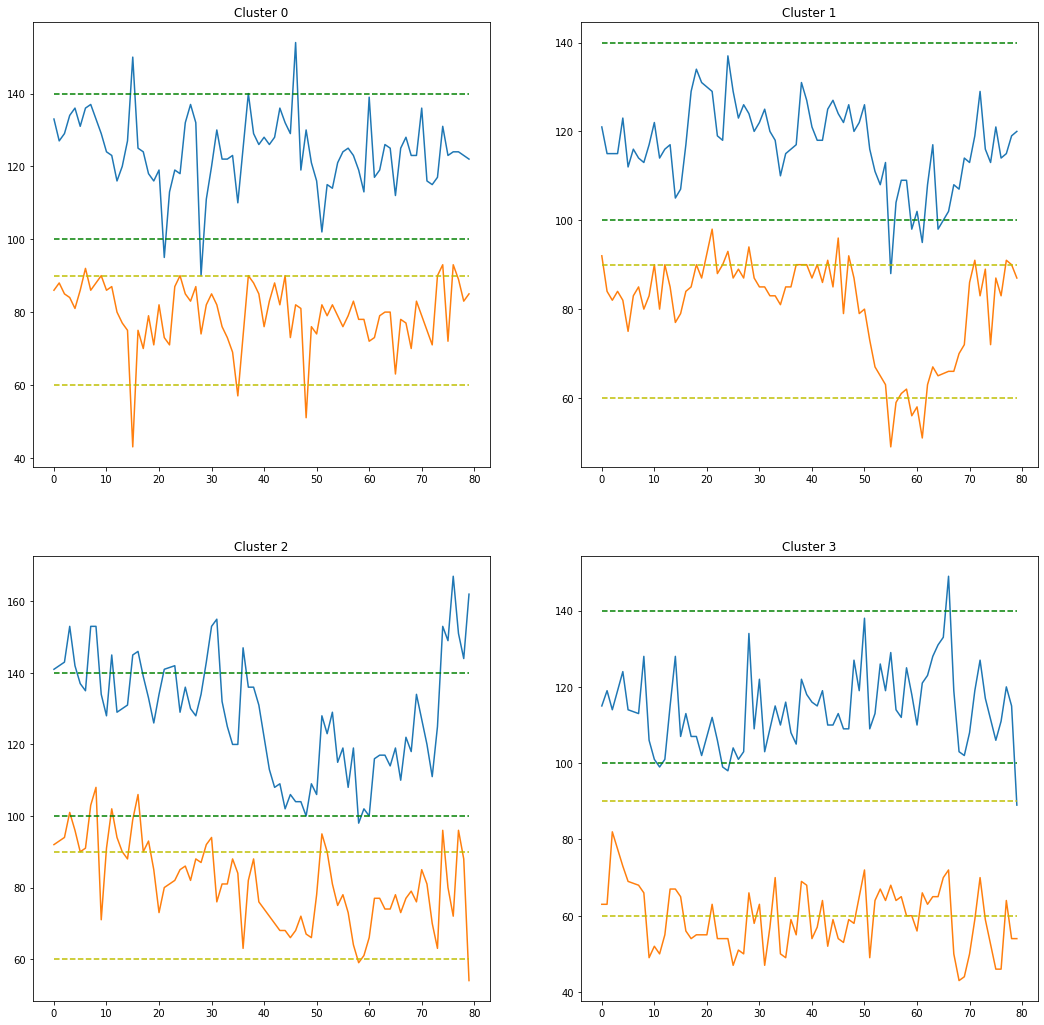

In [0]:
# Identifica os clusters que representam cada um dos dados de entrada
nrows = np.where(z==1)
print(nrows[1])
print(mi.iloc[1])
figure1, axs = plt.subplots(int(n_centr/2),2,figsize=(18,18))
for i in range(3):
  cluster = np.where(nrows[1]==2*i)
  index = np.random.choice(cluster[0])
  axs[i,0].plot(np.arange(80),new_input.iloc[index,0:80])
  axs[i,0].plot(np.arange(80),new_input.iloc[index,80:160])
  axs[i,0].plot(np.arange(80),140*np.ones((80,1)),'g--')
  axs[i,0].plot(np.arange(80),100*np.ones((80,1)),'g--')
  axs[i,0].plot(np.arange(80),90*np.ones((80,1)),'y--')
  axs[i,0].plot(np.arange(80),60*np.ones((80,1)),'y--')
  axs[i,0].set_title('Cluster {}'.format(2*i))
  cluster = np.where(nrows[1]==(2*i+1))
  index = np.random.choice(cluster[0])
  axs[i,1].plot(np.arange(80),new_input.iloc[index,0:80])
  axs[i,1].plot(np.arange(80),new_input.iloc[index,80:160])
  axs[i,1].plot(np.arange(80),140*np.ones((80,1)),'g--')
  axs[i,1].plot(np.arange(80),100*np.ones((80,1)),'g--')
  axs[i,1].plot(np.arange(80),90*np.ones((80,1)),'y--')
  axs[i,1].plot(np.arange(80),60*np.ones((80,1)),'y--')
  axs[i,1].set_title('Cluster {}'.format(2*i+1))
plt.savefig('clusters.png')

## Clusterização de pacientes nos critérios de Isolated Systolic e Diastolic

In [0]:
# Identifica o tamanho do dataset e os nomes das colunas
print('Size of dataset: ' + str(df.shape ))
#print(list(df))  # print feature list

# Cria um novo dataset
isolated = {'PS Max Ratio':new_input.loc[:,'sist 9:00':'sist 8:30'].max(axis=1)/140.0,'PD Mean Ratio':new_input.loc[:,'diast 9:00':'diast 8:30'].mean(axis=1)/90.0,'PD Max Ratio':new_input.loc[:,'diast 9:00':'diast 8:30'].max(axis=1)/90.0,'PS Mean Ratio':new_input.loc[:,'sist 9:00':'sist 8:30'].mean(axis=1)/140.0}
input_isolated = pd.DataFrame(isolated)
input_isolated.head()

#start_noite = new_input.columns.get_loc("sist 23:00")
#end_noite = new_input.columns.get_loc("sist 5:30")

Size of dataset: (7711, 163)


,PS Max Ratio,PD Mean Ratio,PD Max Ratio,PS Mean Ratio
3,1.264286,0.883193,1.155556,0.942857
6,1.114286,0.844515,1.077778,0.870976
40,1.000000,0.843319,1.011111,0.833906
53,1.335714,0.683826,1.000000,0.912025
60,1.164286,0.900211,1.222222,0.892269


### Isolated Systolic - Distância Euclidiana

Realiza a clusterização com a inicialização dos representantes dos clusteres de maneira aleatória, escolhendo-os randomicamente com base nos dados de entrada. Utiliza a métrica da distância euclidiana

In [0]:
# Define o número de centroides/clusters
n_centr = 4
# Define o número de elementos do centroide
n_elem = 2
# Inicializa os centroides aleatoriamente
mi = input_isolated.iloc[:,0:2].sample(n_centr)
D = np.zeros((699,n_centr))
z = np.zeros((699,n_centr))
mi_old = np.copy(mi)
counter = 0
deltaMi = 1000

# Utilizado a distância euclidiana
while(deltaMi>0.001):
  ## Etapa de Expectativa (Expectation Step)
  for i in range(699):
    for j in range(n_centr):
      D[i,j] = distance.euclidean(input_isolated.iloc[i,0:n_elem].values,mi.iloc[j])
      
  for i in range(699):
    for j in range(n_centr):
        if(j == np.argmin(D[i,:])):
          z[i,j] = 1
        else:
          z[i,j] = 0
  # Etapa de Maximização - Maximization Step
  for j in range(n_centr):
    z_sum = 0
    for i in range(699):
      z_sum = z_sum + z[i,j]*(input_isolated.iloc[i,0:n_elem].values)
    mi.iloc[j] = z_sum/np.sum(z[:,j])
    #print(mi)
  counter = counter + 1
  deltaMi = np.abs(np.sum(np.sum(mi-mi_old)))
  print(deltaMi)
  mi_old = np.copy(mi)

0.13646961571503813
0.0606812649646129
0.017634596886348608
0.005297016819692635
0.007022939516479698
0.006215440868903022
0.0044538380983449866
0.006115137497504253
0.0


Plota os clusters inserindo tendo o eixo x como o percentual entre as médias da pressão sistólica média e o eixo y como o percentual das médias da pressão diastólica

      PS Max Ratio  PD Mean Ratio
5152      1.019195       0.805768
1631      1.137867       0.962943
3         1.248944       0.828670
150       1.497619       0.962455


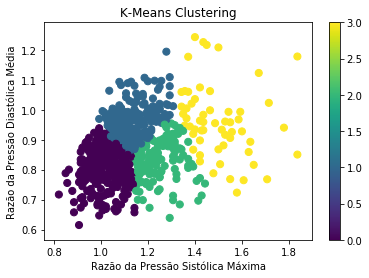

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(input_isolated['PS Max Ratio'],input_isolated['PD Mean Ratio'],
                     c=np.where(z==1)[1],s=50,cmap='viridis')
ax.set_title('K-Means Clustering')
ax.set_xlabel('Razão da Pressão Sistólica Máxima')
ax.set_ylabel('Razão da Pressão Diastólica Média')
plt.colorbar(scatter)
plt.savefig('K-meansIsolated.png')
print(mi)

### Seleciona um representante de cada cluster e plota o gráfico

In [0]:
# Identifica os clusters que representam cada um dos dados de entrada
nrows = np.where(z==1)
print(nrows[1])
print(mi.iloc[1])
figure1, axs = plt.subplots(int(n_centr/2),2,figsize=(18,18))
for i in range(2):
  cluster = np.where(nrows[1]==2*i)
  index = np.random.choice(cluster[0])
  axs[i,0].plot(np.arange(80),new_input.iloc[index,0:80])
  axs[i,0].plot(np.arange(80),new_input.iloc[index,80:160])
  axs[i,0].plot(np.arange(80),140*np.ones((80,1)),'g--')
  axs[i,0].plot(np.arange(80),(new_input.iloc[index,0:80].mean())*np.ones((80,1)),'k--')
  axs[i,0].plot(np.arange(80),100*np.ones((80,1)),'g--')
  axs[i,0].plot(np.arange(80),90*np.ones((80,1)),'y--')
  axs[i,0].plot(np.arange(80),(new_input.iloc[index,80:160].mean())*np.ones((80,1)),'k--')
  axs[i,0].plot(np.arange(80),60*np.ones((80,1)),'y--')
  axs[i,0].set_title('Cluster {}'.format(2*i))
  cluster = np.where(nrows[1]==(2*i+1))
  index = np.random.choice(cluster[0])
  axs[i,1].plot(np.arange(80),new_input.iloc[index,0:80])
  axs[i,1].plot(np.arange(80),new_input.iloc[index,80:160])
  axs[i,1].plot(np.arange(80),140*np.ones((80,1)),'g--')
  axs[i,1].plot(np.arange(80),(new_input.iloc[index,0:80].mean())*np.ones((80,1)),'k--')
  axs[i,1].plot(np.arange(80),100*np.ones((80,1)),'g--')
  axs[i,1].plot(np.arange(80),90*np.ones((80,1)),'y--')
  axs[i,1].plot(np.arange(80),(new_input.iloc[index,80:160].mean())*np.ones((80,1)),'k--')
  axs[i,1].plot(np.arange(80),60*np.ones((80,1)),'y--')
  axs[i,1].set_title('Cluster {}'.format(2*i+1))
plt.savefig('clusters.png')

NameError: ignored

## Isolated Systolic - Distância cityblock (Manhattan)

In [0]:
# Define o número de centroides/clusters
n_centr = 4
# Define o número de elementos do centroide
n_elem = 2
# Inicializa os centroides aleatoriamente
mi = input_isolated.iloc[:,0:2].sample(n_centr)
D = np.zeros((699,n_centr))
z = np.zeros((699,n_centr))
mi_old = np.copy(mi)
counter = 0
deltaMi = 1000

# Utilizado a distância cityblock
while(deltaMi>0.001):
  ## Etapa de Expectativa (Expectation Step)
  for i in range(699):
    for j in range(n_centr):
      D[i,j] = distance.cityblock(input_isolated.iloc[i,0:n_elem].values,mi.iloc[j])
      
  for i in range(699):
    for j in range(n_centr):
        if(j == np.argmin(D[i,:])):
          z[i,j] = 1
        else:
          z[i,j] = 0
  # Etapa de Maximização - Maximization Step
  for j in range(n_centr):
    z_sum = 0
    for i in range(699):
      z_sum = z_sum + z[i,j]*(input_isolated.iloc[i,0:n_elem].values)
    mi.iloc[j] = z_sum/np.sum(z[:,j])
    #print(mi)
  counter = counter + 1
  deltaMi = np.abs(np.sum(np.sum(mi-mi_old)))
  print(deltaMi)
  mi_old = np.copy(mi)

Plota os clusters inserindo tendo o eixo x como o percentual entre as médias da pressão sistólica média e o eixo y como o percentual das médias da pressão diastólica

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(input_isolated['PS Max Ratio'],input_isolated['PD Mean Ratio'],
                     c=np.where(z==1)[1],s=50,cmap='viridis')
ax.set_title('K-Means Clustering - Manhatan')
ax.set_xlabel('Razão da Pressão Sistólica Máxima')
ax.set_ylabel('Razão da Pressão Diastólica Média')
plt.colorbar(scatter)
plt.savefig('K-meansIsolatedCity.png')
print(mi)

### Seleciona um representante de cada cluster e plota o gráfico

In [0]:
# Identifica os clusters que representam cada um dos dados de entrada
nrows = np.where(z==1)
print(nrows[1])
print(mi.iloc[1])
figure1, axs = plt.subplots(int(n_centr/2),2,figsize=(18,18))
for i in range(2):
  cluster = np.where(nrows[1]==2*i)
  index = np.random.choice(cluster[0])
  axs[i,0].plot(np.arange(80),new_input.iloc[index,0:80])
  axs[i,0].plot(np.arange(80),new_input.iloc[index,80:160])
  axs[i,0].plot(np.arange(80),140*np.ones((80,1)),'g--')
  axs[i,0].plot(np.arange(80),(new_input.iloc[index,0:80].mean())*np.ones((80,1)),'k--')
  axs[i,0].plot(np.arange(80),100*np.ones((80,1)),'g--')
  axs[i,0].plot(np.arange(80),90*np.ones((80,1)),'y--')
  axs[i,0].plot(np.arange(80),(new_input.iloc[index,80:160].mean())*np.ones((80,1)),'k--')
  axs[i,0].plot(np.arange(80),60*np.ones((80,1)),'y--')
  axs[i,0].set_title('Cluster {}'.format(2*i))
  cluster = np.where(nrows[1]==(2*i+1))
  index = np.random.choice(cluster[0])
  axs[i,1].plot(np.arange(80),new_input.iloc[index,0:80])
  axs[i,1].plot(np.arange(80),new_input.iloc[index,80:160])
  axs[i,1].plot(np.arange(80),140*np.ones((80,1)),'g--')
  axs[i,1].plot(np.arange(80),(new_input.iloc[index,0:80].mean())*np.ones((80,1)),'k--')
  axs[i,1].plot(np.arange(80),100*np.ones((80,1)),'g--')
  axs[i,1].plot(np.arange(80),90*np.ones((80,1)),'y--')
  axs[i,1].plot(np.arange(80),(new_input.iloc[index,80:160].mean())*np.ones((80,1)),'k--')
  axs[i,1].plot(np.arange(80),60*np.ones((80,1)),'y--')
  axs[i,1].set_title('Cluster {}'.format(2*i+1))
plt.savefig('clustersIsolatedSisMan.png')

## Isolated Diastolic
### Inicialização dos representantes dos cluster fazendo a escolha aleatória sobre o dataset de entrada

Realiza a clusterização com a inicialização dos representantes dos clusteres de maneira aleatória, escolhendo-os randomicamente com base nos dados de entrada. Utiliza a métrica da distância euclidiana

In [0]:
# Define o número de centroides/clusters
n_centr = 4
# Define o número de elementos do centroide
n_elem = 2
# Inicializa os centroides aleatoriamente
mi = input_isolated.iloc[:,2:4].sample(n_centr)
D = np.zeros((699,n_centr))
z = np.zeros((699,n_centr))
mi_old = np.copy(mi)
counter = 0
deltaMi = 1000
while(deltaMi>0.001):
  ## Etapa de Expectativa (Expectation Step)
  for i in range(699):
    for j in range(n_centr):
      D[i,j] = distance.euclidean(input_isolated.iloc[i,2:2+n_elem].values,mi.iloc[j])
      
  for i in range(699):
    for j in range(n_centr):
        if(j == np.argmin(D[i,:])):
          z[i,j] = 1
        else:
          z[i,j] = 0
  # Etapa de Maximização - Maximization Step
  for j in range(n_centr):
    z_sum = 0
    for i in range(699):
      z_sum = z_sum + z[i,j]*(input_isolated.iloc[i,2:2+n_elem].values)
    mi.iloc[j] = z_sum/np.sum(z[:,j])
    #print(mi)
  counter = counter + 1
  deltaMi = np.abs(np.sum(np.sum(mi-mi_old)))
  print(deltaMi)
  mi_old = np.copy(mi)

Plota os clusters inserindo tendo o eixo x como o percentual entre as médias da pressão sistólica média e o eixo y como o percentual das médias da pressão diastólica

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(input_isolated['PD Max Ratio'],input_isolated['PS Mean Ratio'],
                     c=np.where(z==1)[1],s=50,cmap='viridis')
ax.set_title('K-Means Clustering - Euclidiana')
ax.set_xlabel('Razão da Pressão Sistólica Média')
ax.set_ylabel('Razão da Pressão Diastólica Máxima')
plt.colorbar(scatter)
plt.savefig('K-meansIsolatedD.png')
print(mi)

### Seleciona um representante de cada cluster e plota o gráfico

In [0]:
# Identifica os clusters que representam cada um dos dados de entrada
nrows = np.where(z==1)
print(nrows[1])
print(mi.iloc[1])
figure1, axs = plt.subplots(2,2,figsize=(18,18))
for i in range(2):
  cluster = np.where(nrows[1]==2*i)
  index = np.random.choice(cluster[0])
  axs[i,0].plot(np.arange(80),new_input.iloc[index,0:80])
  axs[i,0].plot(np.arange(80),new_input.iloc[index,80:160])
  axs[i,0].plot(np.arange(80),140*np.ones((80,1)),'g--')
  axs[i,0].plot(np.arange(80),(new_input.iloc[index,0:80].mean())*np.ones((80,1)),'k--')
  axs[i,0].plot(np.arange(80),100*np.ones((80,1)),'g--')
  axs[i,0].plot(np.arange(80),90*np.ones((80,1)),'y--')
  axs[i,0].plot(np.arange(80),(new_input.iloc[index,80:160].mean())*np.ones((80,1)),'k--')
  axs[i,0].plot(np.arange(80),60*np.ones((80,1)),'y--')
  axs[i,0].set_title('Cluster {}'.format(2*i))
  cluster = np.where(nrows[1]==(2*i+1))
  index = np.random.choice(cluster[0])
  axs[i,1].plot(np.arange(80),new_input.iloc[index,0:80])
  axs[i,1].plot(np.arange(80),new_input.iloc[index,80:160])
  axs[i,1].plot(np.arange(80),140*np.ones((80,1)),'g--')
  axs[i,1].plot(np.arange(80),(new_input.iloc[index,0:80].mean())*np.ones((80,1)),'k--')
  axs[i,1].plot(np.arange(80),100*np.ones((80,1)),'g--')
  axs[i,1].plot(np.arange(80),90*np.ones((80,1)),'y--')
  axs[i,1].plot(np.arange(80),(new_input.iloc[index,80:160].mean())*np.ones((80,1)),'k--')
  axs[i,1].plot(np.arange(80),60*np.ones((80,1)),'y--')
  axs[i,1].set_title('Cluster {}'.format(2*i+1))
plt.savefig('clustersIsolatedDiast.png')

## Isolated Diastolic - Manhatan

Realiza a clusterização com a inicialização dos representantes dos clusteres de maneira aleatória, escolhendo-os randomicamente com base nos dados de entrada. Utiliza a métrica da distância Manhatan

In [0]:
# Define o número de centroides/clusters
n_centr = 4
# Define o número de elementos do centroide
n_elem = 2
# Inicializa os centroides aleatoriamente
mi = input_isolated.iloc[:,2:4].sample(n_centr)
## Etapa de Expectativa (Expectation Step)
D = np.zeros((699,n_centr))
z = np.zeros((699,n_centr))
mi_old = np.copy(mi)
counter = 0
deltaMi = 1000
while(deltaMi>0.001):
  for i in range(699):
    for j in range(n_centr):
      D[i,j] = distance.cityblock(input_isolated.iloc[i,2:2+n_elem].values,mi.iloc[j])
      
  for i in range(699):
    for j in range(n_centr):
        if(j == np.argmin(D[i,:])):
          z[i,j] = 1
        else:
          z[i,j] = 0
  # Etapa de Maximização - Maximization Step
  for j in range(n_centr):
    z_sum = 0
    for i in range(699):
      z_sum = z_sum + z[i,j]*(input_isolated.iloc[i,2:2+n_elem].values)
    mi.iloc[j] = z_sum/np.sum(z[:,j])
    #print(mi)
  counter = counter + 1
  deltaMi = np.abs(np.sum(np.sum(mi-mi_old)))
  print(deltaMi)
  mi_old = np.copy(mi)

Plota os clusters inserindo tendo o eixo x como o percentual entre as médias da pressão sistólica média e o eixo y como o percentual das médias da pressão diastólica

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(input_isolated['PD Max Ratio'],input_isolated['PS Mean Ratio'],
                     c=np.where(z==1)[1],s=50,cmap='viridis')
ax.set_title('K-Means Clustering - Manhatan')
ax.set_xlabel('Razão da Pressão Sistólica Média')
ax.set_ylabel('Razão da Pressão Diastólica Máxima')
plt.colorbar(scatter)
plt.savefig('K-meansIsolatedDCity.png')
print(mi)

### Seleciona um representante de cada cluster e plota o gráfico

In [0]:
# Identifica os clusters que representam cada um dos dados de entrada
nrows = np.where(z==1)
print(nrows[1])
print(mi.iloc[1])
figure1, axs = plt.subplots(2,2,figsize=(18,18))
for i in range(2):
  cluster = np.where(nrows[1]==2*i)
  index = np.random.choice(cluster[0])
  axs[i,0].plot(np.arange(80),new_input.iloc[index,0:80])
  axs[i,0].plot(np.arange(80),new_input.iloc[index,80:160])
  axs[i,0].plot(np.arange(80),140*np.ones((80,1)),'g--')
  axs[i,0].plot(np.arange(80),(new_input.iloc[index,0:80].mean())*np.ones((80,1)),'k--')
  axs[i,0].plot(np.arange(80),100*np.ones((80,1)),'g--')
  axs[i,0].plot(np.arange(80),90*np.ones((80,1)),'y--')
  axs[i,0].plot(np.arange(80),(new_input.iloc[index,80:160].mean())*np.ones((80,1)),'k--')
  axs[i,0].plot(np.arange(80),60*np.ones((80,1)),'y--')
  axs[i,0].set_title('Cluster {}'.format(2*i))
  cluster = np.where(nrows[1]==(2*i+1))
  index = np.random.choice(cluster[0])
  axs[i,1].plot(np.arange(80),new_input.iloc[index,0:80])
  axs[i,1].plot(np.arange(80),new_input.iloc[index,80:160])
  axs[i,1].plot(np.arange(80),140*np.ones((80,1)),'g--')
  axs[i,1].plot(np.arange(80),(new_input.iloc[index,0:80].mean())*np.ones((80,1)),'k--')
  axs[i,1].plot(np.arange(80),100*np.ones((80,1)),'g--')
  axs[i,1].plot(np.arange(80),90*np.ones((80,1)),'y--')
  axs[i,1].plot(np.arange(80),(new_input.iloc[index,80:160].mean())*np.ones((80,1)),'k--')
  axs[i,1].plot(np.arange(80),60*np.ones((80,1)),'y--')
  axs[i,1].set_title('Cluster {}'.format(2*i+1))
plt.savefig('clusters.png')

## Isolated Diastolic - Chebyshev

Realiza a clusterização com a inicialização dos representantes dos clusteres de maneira aleatória, escolhendo-os randomicamente com base nos dados de entrada. Utiliza a métrica da distância Chebyshev, que calcula a distância como a máxima diferença entre cada um dos itens do vetor

In [0]:
# Define o número de centroides/clusters
n_centr = 4
# Define o número de elementos do centroide
n_elem = 2
# Inicializa os centroides aleatoriamente
mi = input_isolated.iloc[:,2:4].sample(n_centr)
## Etapa de Expectativa (Expectation Step)
D = np.zeros((699,n_centr))
z = np.zeros((699,n_centr))
mi_old = np.copy(mi)
counter = 0
deltaMi = 1000
while(deltaMi>0.001):
  for i in range(699):
    for j in range(n_centr):
      D[i,j] = distance.chebyshev(input_isolated.iloc[i,2:2+n_elem].values,mi.iloc[j])
      
  for i in range(699):
    for j in range(n_centr):
        if(j == np.argmin(D[i,:])):
          z[i,j] = 1
        else:
          z[i,j] = 0
  # Etapa de Maximização - Maximization Step
  for j in range(n_centr):
    z_sum = 0
    for i in range(699):
      z_sum = z_sum + z[i,j]*(input_isolated.iloc[i,2:2+n_elem].values)
    mi.iloc[j] = z_sum/np.sum(z[:,j])
    #print(mi)
  counter = counter + 1
  deltaMi = np.abs(np.sum(np.sum(mi-mi_old)))
  print(deltaMi)
  mi_old = np.copy(mi)

Plota os clusters inserindo tendo o eixo x como o percentual entre as médias da pressão sistólica média e o eixo y como o percentual das médias da pressão diastólica

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(input_isolated['PD Max Ratio'],input_isolated['PS Mean Ratio'],
                     c=np.where(z==1)[1],s=50,cmap='viridis')
ax.set_title('K-Means Clustering - Chebyshev')
ax.set_xlabel('Razão da Pressão Sistólica Média')
ax.set_ylabel('Razão da Pressão Diastólica Máxima')
plt.colorbar(scatter)
plt.savefig('K-meansIsolatedDCheb.png')
print(mi)

### Seleciona um representante de cada cluster e plota o gráfico

In [0]:
# Identifica os clusters que representam cada um dos dados de entrada
nrows = np.where(z==1)
print(nrows[1])
print(mi.iloc[1])
figure1, axs = plt.subplots(2,2,figsize=(18,18))
for i in range(2):
  cluster = np.where(nrows[1]==2*i)
  index = np.random.choice(cluster[0])
  axs[i,0].plot(np.arange(80),new_input.iloc[index,0:80])
  axs[i,0].plot(np.arange(80),new_input.iloc[index,80:160])
  axs[i,0].plot(np.arange(80),140*np.ones((80,1)),'g--')
  axs[i,0].plot(np.arange(80),(new_input.iloc[index,0:80].mean())*np.ones((80,1)),'k--')
  axs[i,0].plot(np.arange(80),100*np.ones((80,1)),'g--')
  axs[i,0].plot(np.arange(80),90*np.ones((80,1)),'y--')
  axs[i,0].plot(np.arange(80),(new_input.iloc[index,80:160].mean())*np.ones((80,1)),'k--')
  axs[i,0].plot(np.arange(80),60*np.ones((80,1)),'y--')
  axs[i,0].set_title('Cluster {}'.format(2*i))
  cluster = np.where(nrows[1]==(2*i+1))
  index = np.random.choice(cluster[0])
  axs[i,1].plot(np.arange(80),new_input.iloc[index,0:80])
  axs[i,1].plot(np.arange(80),new_input.iloc[index,80:160])
  axs[i,1].plot(np.arange(80),140*np.ones((80,1)),'g--')
  axs[i,1].plot(np.arange(80),(new_input.iloc[index,0:80].mean())*np.ones((80,1)),'k--')
  axs[i,1].plot(np.arange(80),100*np.ones((80,1)),'g--')
  axs[i,1].plot(np.arange(80),90*np.ones((80,1)),'y--')
  axs[i,1].plot(np.arange(80),(new_input.iloc[index,80:160].mean())*np.ones((80,1)),'k--')
  axs[i,1].plot(np.arange(80),60*np.ones((80,1)),'y--')
  axs[i,1].set_title('Cluster {}'.format(2*i+1))
plt.savefig('clusters.png')